<a href="https://colab.research.google.com/github/Jmerinom22/Codigo-Proyecto/blob/main/Modelo_ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Base de datos **(La Paz)**

In [1]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

archivo = list(uploaded.keys())[0]
df = pd.read_csv(archivo, sep=';')  # Quien use este codigo asegúrate de usar el separador correcto

num_observaciones, num_variables = df.shape
print(f"Número de observaciones (filas): {num_observaciones}")
print(f"Número de variables (columnas): {num_variables}")

print("\n Lista de variables:")
print(df.columns.tolist())

Saving base_datos_solar_lapaz_2025 (1).csv to base_datos_solar_lapaz_2025 (1).csv
Número de observaciones (filas): 2880
Número de variables (columnas): 6

 Lista de variables:
['time', 'shortwave_radiation', 'temperature_2m', 'wind_speed_10m', 'relative_humidity_2m', 'energia_solar_kWh']


# Aproximaciones

## Modelo ARMA

- AR (AutoRegresivo): se basa en los valores anteriores (lags) de la variable.
- MA (Media Móvil): se basa en el error de predicciones anteriores.
- ARMA mezcla ambos.

Pero importante: ARMA solo usa la variable objetivo (no usa otras variables).

### Preparar la serie de tiempo

Vamos a quedarnos solo con la columna `energia_solar_kWh` y asegurarnos de que esté indexada por el tiempo.

In [16]:
serie_energia = df.set_index('time')['energia_solar_kWh']

serie_energia.head()

,energia_solar_kWh
time,
2025-02-01T00:00,0.0
2025-02-01T01:00,0.0
2025-02-01T02:00,0.0
2025-02-01T03:00,0.0
2025-02-01T04:00,0.0


### Ajustar el modelo ARMA

Probaremos con un modelo básico de orden (p=2, q=2):

- p = 2: número de lags (valores anteriores)
- q = 2: número de errores pasados

In [17]:
from statsmodels.tsa.arima.model import ARIMA

modelo_arma = ARIMA(serie_energia, order=(2, 0, 2))
resultado_arma = modelo_arma.fit()

print(resultado_arma.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      energia_solar_kWh   No. Observations:                 2880
Model:                 ARIMA(2, 0, 2)   Log Likelihood                7588.652
Date:                Fri, 25 Jul 2025   AIC                         -15165.303
Time:                        19:55:34   BIC                         -15129.510
Sample:                    02-01-2025   HQIC                        -15152.402
                         - 05-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0677      0.003     22.255      0.000       0.062       0.074
ar.L1          1.7431      0.013    131.512      0.000       1.717       1.769
ar.L2         -0.8569      0.013    -67.883      0.0

 El modelo ARMA(2,0,2) se ajustó correctamente.

| Resultado         | Interpretación                                                               |
| ----------------- | ---------------------------------------------------------------------------- |
| `const ≈ 0.0677`  | Valor promedio base de energía solar.                                        |
| `ar.L1, ar.L2`    | La energía pasada tiene un fuerte efecto (especialmente la de 1 hora antes). |
| `ma.L1, ma.L2`    | El modelo también ajusta errores pasados para corregirse.                    |
| `sigma2 ≈ 0.0003` | Varianza del error muy baja → modelo preciso.                                |
| `AIC = -15165`    | Es una métrica que puede usarse para comparar modelos ARMA entre sí.         |
| `Prob(JB) = 0.00` | Los residuos **no son normales** (algo común en datos solares).              |
                                                           |


- El modelo aprendió bien el patrón horario de la serie de energía.
- La energía de 1 y 2 horas antes explican buena parte del valor actual.
- Aunque es un modelo solo univariado, logra captar bien el comportamiento de la energía.

### predicciones con el modelo ARMA

- Predecir los últimos 20% de los datos (igual que hicimos en XGBoost).
- Comparar los valores reales vs predichos.
- Calcular RMSE y R² para poder comparar con los otros modelos.

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

n_test = 572
inicio = len(serie_energia) - n_test

predicciones_arma = resultado_arma.predict(start=inicio, end=len(serie_energia)-1)

reales = serie_energia.iloc[inicio:]

rmse_arma = np.sqrt(mean_squared_error(reales, predicciones_arma))
r2_arma = r2_score(reales, predicciones_arma)

print(f" RMSE (ARMA): {rmse_arma:.4f}")
print(f" R² (ARMA): {r2_arma:.4f}")

 RMSE (ARMA): 0.0212
 R² (ARMA): 0.9323


1. El modelo ARMA logró un buen ajuste solo con los valores pasados de la energía.

2. Aunque es un modelo clásico, se comportó bastante bien:

  - Su RMSE es un poco mayor que el de XGBoost (0.021)

  - Su R² es menor (93.2% vs 97.6%), pero sigue siendo aceptable

3. No usamos ninguna variable meteorológica, solo la secuencia histórica.

In [20]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

reales_np = reales.to_numpy()
pred_np = predicciones_arma.to_numpy()

mae_arma = mean_absolute_error(reales_np, pred_np)

mask = reales_np > 0.25
mape_arma = np.mean(np.abs((reales_np[mask] - pred_np[mask]) / reales_np[mask])) * 100

print(f" MAE (ARMA): {mae_arma:.4f}")
print(f" MAPE filtrado (ARMA): {mape_arma:.2f}%")

 MAE (ARMA): 0.0145
 MAPE filtrado (ARMA): 10.39%


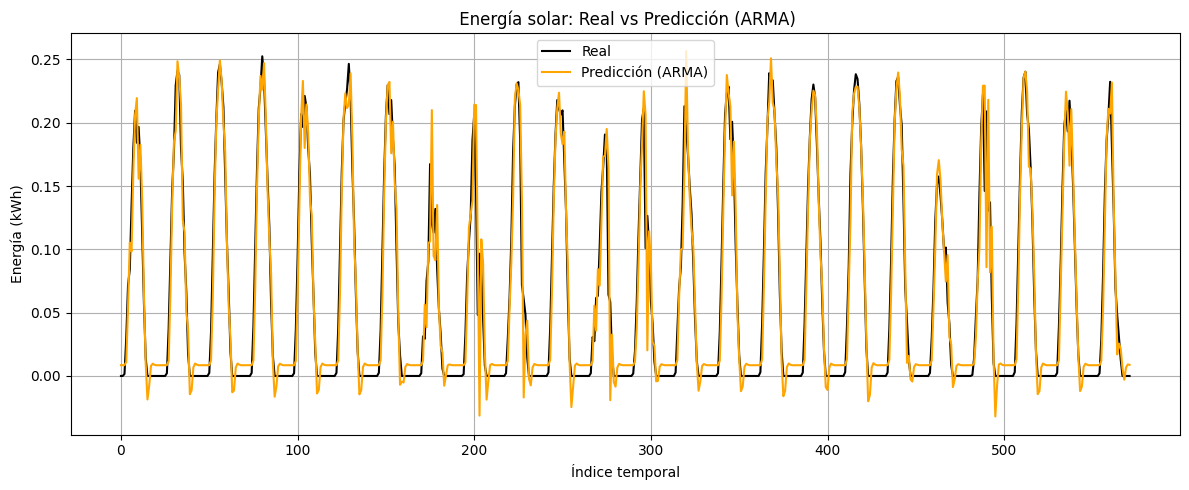

In [21]:
# Gráfica
plt.figure(figsize=(12, 5))
plt.plot(reales_np, label='Real', color='black')
plt.plot(pred_np, label='Predicción (ARMA)', color='orange')
plt.title(' Energía solar: Real vs Predicción (ARMA)')
plt.xlabel('Índice temporal')
plt.ylabel('Energía (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

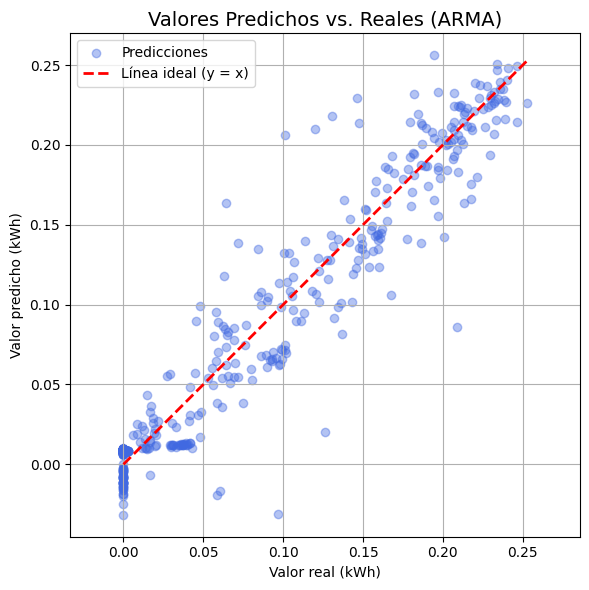

In [22]:
import matplotlib.pyplot as plt

reales_np = reales.to_numpy()
pred_np = predicciones_arma.to_numpy()

plt.figure(figsize=(6, 6))
plt.scatter(reales_np, pred_np, alpha=0.4, color='royalblue', label='Predicciones')
plt.plot([reales_np.min(), reales_np.max()],
         [reales_np.min(), reales_np.max()],
         color='red', linestyle='--', linewidth=2, label='Línea ideal (y = x)')

plt.title('Valores Predichos vs. Reales (ARMA)', fontsize=14)
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()
